# Logistic Regression

## We have taken Amazon Dataset and applied Logistic regression to evaluate value of c so as to get the value of lambda where c= 1/lambda.Also We have used GridsearchCV with L1 and L2 distance and RandomsearchCV with L1 and L2 distance.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from scipy import stats

import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score


C:\Users\Soni\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading the Amazon Text Review Dataset and cleaning,Pre-processing,removing stop words and sorting it with the time.

In [2]:
conn = sqlite3.connect('final.sqlite')#Loading the Data set
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)

In [3]:
final.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [4]:
final.shape

(364171, 12)

In [3]:
final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')#Sorting the data according to the Time in ascending order

### Taking 100K sorted values for Logistic Regression

In [4]:
x = final['CleanedText'].values[0:100000]#Taking 100K Values 
y = final['Score'].values[0:100000]

### Spliiting the data into Train and Test with 70K points for Train and 30K for Test.

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state=42)#Splitting the data into Test and Train

In [6]:
#Plot Confusion Matrix for the dataset
from sklearn.metrics import confusion_matrix
import itertools   
def plot_confusion_matrix(cm, classes,
      
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
     #else:
      #  print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [18]:
def important_features (vectorizer,classifier,class_labels,n):#Function to print important features
    class_lables = classifier.classes_
    features_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], features_names),reverse=True)
    if class_labels =='negative':#Feature for negative class
        print("Important words in negative reviews")
        for coef, feat in topn_class1[:-(n+1):-1]:
            print(class_labels[0], coef,feat)
    if class_labels =='positive':#Feature for Positive class
        print("Important words in positive reviews")
        for coef, feat in topn_class1[:n]:
            print(class_labels[1], coef,feat)
    

# Logistic regression on Bag of Words 

### Vectorizing the data for Bag of Words.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() #Vectorization for BOW
X_train = count_vect.fit_transform(x_train)# Fitting and training our dataset on train dataset
X_test = count_vect.transform(x_test)
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)


Train Data Size:  (70000, 31419)
Test Data Size:  (30000, 31419)


In [9]:
from sklearn import preprocessing
#Column Standardization of the values with Mean deviation
scaler = preprocessing.StandardScaler(copy=True, with_mean=False, with_std=True)
X1_train = scaler.fit_transform(X_train)
X1_test = scaler.fit_transform(X_test)

### Using GridSearchCV 

In [12]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]#Giving specifiv values to pass through GridsearchCV

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)#Passing Tuned parameters with F1 Weighted Scoring
model.fit(X1_train, y_train)


print(model.best_estimator_)#Prints value of C with given values in Tuned Parameters
print ("The F1 score is :")
print(model.score(X1_test, y_test))#Prints the F1 Score

C:\Users\Soni\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The F1 score is :
0.9115560803211248


### Value of C = 0.01
### F1 Score = 0.91

In [10]:
from sklearn.linear_model import LogisticRegression
import numpy as np

clf = LogisticRegression(C=0.01, penalty='l1');#Passing LR with L1 distance
clf.fit(X1_train, y_train);
y_pred = clf.predict(X1_test)
w = clf.coef_
print ("The Weight with C = 0.01 with L1 Reg")
print(np.count_nonzero(w))#Counting the sparsity of weight vector.


The Weight with C = 0.01 with L1 Reg
3238


### The Weight W with C = 0.01 for L1 Distance is 3238

# Top 50 Features for Negative class for BOW

In [11]:
important_features (count_vect,clf,'negative',50)

Important words in negative reviews
n -0.29296959018540086 disappoint
n -0.20142409483823318 worst
n -0.16789649525087896 terribl
n -0.1647427262215395 horribl
n -0.15877784872042178 return
n -0.14916903203521217 tast
n -0.14853867035794252 bad
n -0.1314268981071881 thought
n -0.12887900776281272 money
n -0.12733299027543213 unfortun
n -0.126210776698396 stale
n -0.12617312605553627 aw
n -0.12424899147014705 product
n -0.11258467762508484 threw
n -0.10989259960169534 would
n -0.10806048397431332 bland
n -0.10237044826296708 sorri
n -0.09978740813138716 weak
n -0.09453288790674905 didnt
n -0.09353762675004205 hope
n -0.09120986511900064 tasteless
n -0.09071545537238268 stick
n -0.0905238923943764 wast
n -0.08960873123160254 mayb
n -0.08849298049184327 poor
n -0.08587549050308727 receiv
n -0.085579878915869 wors
n -0.08477304948930692 away
n -0.08473752959697371 noth
n -0.0825001046699864 gross
n -0.08030181745736996 yuck
n -0.08021621001423271 wouldnt
n -0.07695535681913412 someth
n -0.

# Top 50 Features for Positive class for BOW

In [19]:
important_features (count_vect,clf,'positive',50)

Important words in positive reviews
o 0.676471084234991 great
o 0.4685911398633425 best
o 0.4574726155098925 love
o 0.41991854825362757 delici
o 0.33369515227564545 good
o 0.3319671164208473 perfect
o 0.27817223834209914 excel
o 0.24582586838928333 nice
o 0.23977665120742048 favorit
o 0.2383216961515476 wonder
o 0.19975657085224496 amaz
o 0.17428348675236335 addict
o 0.1730719395181811 tasti
o 0.1691153088272904 find
o 0.16457185630291898 easi
o 0.15785568757853533 alway
o 0.15442670859236587 happi
o 0.14783031348909773 thank
o 0.14218568935129702 keep
o 0.13817534266936807 snack
o 0.13173398615557988 enjoy
o 0.1294544072364475 yummi
o 0.12837227995900227 awesom
o 0.1266703180534115 smooth
o 0.12430724280119859 use
o 0.12034566527424514 glad
o 0.12003541447831562 help
o 0.11693212396429083 year
o 0.11613237967256586 fantast
o 0.11517559828978155 high
o 0.1118992521034741 satisfi
o 0.11114516286583366 fast
o 0.10933087351091869 beat
o 0.10815965637540591 store
o 0.10551393015321553 add


In [12]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.9151125300557928, 0.9216333333333333, 0.9122991915202339, None)

### Precision : 0.91
### Recall : 0.92
### F1 Score : 0.92

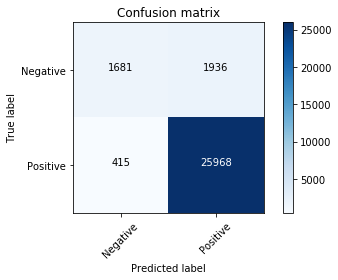

In [13]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

### Confusion matrix depicts it is a Positive biased Model.

In [14]:
acc_bow = accuracy_score(y_test, y_pred, normalize=True) * float(100)#Prints the Accuracy with L1 distance in GridsearchCV
print('\nThe accuracy of C with value %f is %f%%' % (0.01, acc_bow))


The accuracy of C with value 0.010000 is 92.163333%


### The Accuracy for C is 92.16%

In [15]:
print ("The error for with C = 0.01 is ")#Prints the error
err_bow = 100-acc_bow
err_bow

The error for with C = 0.01 is 


7.836666666666673

#### The Error with C = 0.01 is 7.83

# Using GridSearchCV with L2 Distance

In [21]:

import numpy as np

clf1 = LogisticRegression(C=0.01, penalty='l2');#Passing LR with L2 distance
clf1.fit(X1_train, y_train);
y1_pred = clf1.predict(X1_test)
w = clf1.coef_
print ("The Weight with C = 0.01 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 0.01 with L2 Reg
31419


In [22]:
important_features (count_vect,clf1,'positive',50)# Top 50 Features for Positive class

Important words in positive reviews
o 0.863734533335804 great
o 0.6742334176164138 love
o 0.6024398945654228 best
o 0.5398157165877974 delici
o 0.5130238540528688 good
o 0.4640962496371809 perfect
o 0.409433336486667 favorit
o 0.3839779642522559 nice
o 0.35335537413835083 excel
o 0.3413347418023156 wonder
o 0.30967042288302044 awesom
o 0.2988190437209066 addict
o 0.2950064966987291 amaz
o 0.2742789464108289 find
o 0.2551424337605151 smooth
o 0.2513994299290695 easi
o 0.25012595026751444 tasti
o 0.24930775706920114 satisfi
o 0.2392022448432591 glad
o 0.23575796897770024 thank
o 0.23564722630352528 beat
o 0.22678713064856681 high
o 0.2240864201680545 yummi
o 0.2175454866597552 alway
o 0.21320578187759123 cold
o 0.2126366334855568 keep
o 0.2102667041884618 snack
o 0.20958878415679458 hook
o 0.20906412782319672 hit
o 0.20593656420917394 enjoy
o 0.2057156741293216 fresh
o 0.20541493043954978 refresh
o 0.19627895877166152 complaint
o 0.19494243553271703 quick
o 0.19279579670262165 help
o 0.1

In [23]:
important_features (count_vect,clf,'negative',50)# Top 50 Features for Negative class

Important words in negative reviews
n -0.29296959018540086 disappoint
n -0.20142409483823318 worst
n -0.16789649525087896 terribl
n -0.1647427262215395 horribl
n -0.15877784872042178 return
n -0.14916903203521217 tast
n -0.14853867035794252 bad
n -0.1314268981071881 thought
n -0.12887900776281272 money
n -0.12733299027543213 unfortun
n -0.126210776698396 stale
n -0.12617312605553627 aw
n -0.12424899147014705 product
n -0.11258467762508484 threw
n -0.10989259960169534 would
n -0.10806048397431332 bland
n -0.10237044826296708 sorri
n -0.09978740813138716 weak
n -0.09453288790674905 didnt
n -0.09353762675004205 hope
n -0.09120986511900064 tasteless
n -0.09071545537238268 stick
n -0.0905238923943764 wast
n -0.08960873123160254 mayb
n -0.08849298049184327 poor
n -0.08587549050308727 receiv
n -0.085579878915869 wors
n -0.08477304948930692 away
n -0.08473752959697371 noth
n -0.0825001046699864 gross
n -0.08030181745736996 yuck
n -0.08021621001423271 wouldnt
n -0.07695535681913412 someth
n -0.

In [19]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y1_pred, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.9098404106738489, 0.9140666666666667, 0.9115560803211248, None)

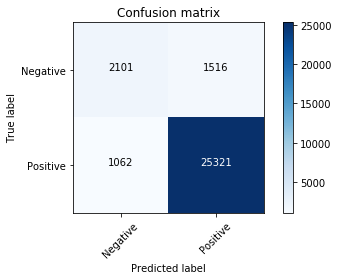

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, y1_pred), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [21]:
acc_bow = accuracy_score(y_test, y1_pred, normalize=True) * float(100)#Prints the Accuracy with L2 distance in GridsearchCV
print('\nThe accuracy of C with value %f is %f%%' % (0.01, acc_bow))


The accuracy of C with value 0.010000 is 91.406667%


In [22]:
print ("The error for with C = 0.01 is ")#Prints the error with L2 distance in GridsearchCV
err_bow = 100-acc_bow
err_bow

The error for with C = 0.01 is 


8.593333333333334

# Randomized SearchCV in BOW

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from scipy import stats
#Giving uniform range to pass through RandomizedsearchCV
tuned_parameters = {'C':stats.uniform(10**-4,10**4)}

model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)
model.fit(X1_train, y_train)


print(model.best_estimator_)#Prints value of C with given values in Tuned Parameters
print ("The F1 score is :")
print(model.score(X1_test, y_test))#Prints the F1 Score 


LogisticRegression(C=5426.183756117079, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The F1 score is :
0.8962704312123442


## Using L1 Distance

In [24]:

import numpy as np

clf2 = LogisticRegression(C=5426.18, penalty='l1');
clf2.fit(X1_train, y_train);
y2_pred = clf2.predict(X1_test)
w = clf2.coef_
print ("The Weight with C = 5426.18 with L1 Reg is ")
print(np.count_nonzero(w))


The Weight with C = 5426.18 with L1 Reg is 
24662


In [27]:
important_features (count_vect,clf2,'negative',50)

Important words in negative reviews
n -0.8771375536666146 monosodium
n -0.8593202373557182 worst
n -0.8286521683081078 carrageenan
n -0.8030071437880466 util
n -0.8005081941534393 centuri
n -0.74480319167546 glutam
n -0.7244152372252806 tetra
n -0.7192179443100399 file
n -0.7179200563495525 misrepres
n -0.6849162259206332 disappoint
n -0.6566846042789167 catalina
n -0.653376385723127 tast
n -0.6521464725099334 marco
n -0.6510898809257868 www
n -0.6436346747803887 deet
n -0.6262815039483433 nozzl
n -0.6182151968461059 wikipedia
n -0.5974912093578657 similac
n -0.5956944344713423 thermogenesi
n -0.5944207474557808 assam
n -0.5780837125423834 madra
n -0.5740471925749642 poof
n -0.5703032533084404 chinotto
n -0.5638353956398072 colicki
n -0.5569700946008851 soap
n -0.5437569720341517 swell
n -0.5424242311341949 nada
n -0.5325391910495836 numi
n -0.5241181838951877 even
n -0.5237376361242193 physiolog
n -0.5157607270569334 worthless
n -0.5032298762631591 taurin
n -0.5013893969072627 stale
n

In [28]:
important_features (count_vect,clf2,'positive',50)

Important words in positive reviews
o 2.0494203103092605 relax
o 1.7792911592195126 great
o 1.4594960564048343 love
o 1.4113413390384544 best
o 1.3806965871622205 vinaigrett
o 1.3310255066861292 yuban
o 1.285182470283487 peac
o 1.2778709569800357 beetlejuic
o 1.274086048560413 delici
o 1.2679573081538114 tvp
o 1.1877900349905666 perfect
o 1.1587886970283643 keeper
o 1.1409770554542713 potassium
o 1.13694765423282 addict
o 1.1153097296559933 dandi
o 1.110038077830133 avenu
o 1.100773203258071 secret
o 1.0756541475264059 insur
o 1.0495702845241053 good
o 1.0430411348547894 vernor
o 1.0201222463209667 hawaiian
o 1.006299777069319 prescript
o 1.0034929470188931 host
o 0.99813548015886 awesom
o 0.9866483409270108 languag
o 0.9843896404943997 amber
o 0.9777566552754722 skeptic
o 0.971109424667127 marmit
o 0.9671964768410675 coriand
o 0.9606912027962337 smile
o 0.9445895760278329 limit
o 0.9435733849274333 steel
o 0.9412568171951139 favorit
o 0.9386114254893283 ratio
o 0.9307810928983169 preh

In [14]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y2_pred, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.883075746391485, 0.8763, 0.8794092766093363, None)

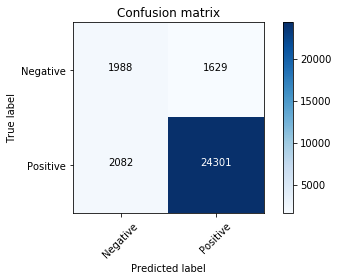

In [15]:
plot_confusion_matrix(confusion_matrix(y_test, y2_pred), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [16]:
acc_bow = accuracy_score(y_test, y2_pred, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (5426.18, acc_bow))


The accuracy of C with value 5426.180000 is 87.630000%


In [17]:
print ("The error for with C = 5426.18 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 5426.18 is 


12.370000000000005

## Using L2 Distance

In [29]:

import numpy as np

clf3 = LogisticRegression(C=5426.18, penalty='l2');
clf3.fit(X1_train, y_train);
y3_pred = clf3.predict(X1_test)
w = clf3.coef_
print ("The Weight with C = 5426.18 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 5426.18 with L2 Reg
31419


In [19]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y3_pred, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.9022384339744236, 0.9019333333333334, 0.9020847621316067, None)

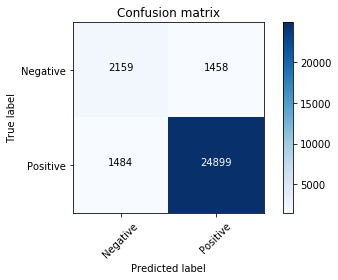

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, y3_pred), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [21]:
acc_bow = accuracy_score(y_test, y3_pred, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (5426.18, acc_bow))


The accuracy of C with value 5426.180000 is 90.193333%


In [22]:
print ("The error for with C = 5426.18 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 5426.18 is 


9.806666666666658

In [30]:
important_features (count_vect,clf3,'positive',50)

Important words in positive reviews
o 1.2754860781527388 great
o 1.0102576611704874 love
o 0.9309778409677294 best
o 0.8586305562781218 delici
o 0.7954462969700349 perfect
o 0.7379892005567178 good
o 0.6563666405779598 favorit
o 0.6006025446759807 nice
o 0.564613871512983 awesom
o 0.5347879541307216 addict
o 0.519642199141917 wonder
o 0.5117861179041151 amaz
o 0.5069770073150205 excel
o 0.43650220407027396 satisfi
o 0.4188820703578463 find
o 0.41172563283694047 smooth
o 0.4033269903570021 insur
o 0.3989994370886557 hit
o 0.3984608101971019 beat
o 0.39231498158420497 hook
o 0.3895729362088991 glad
o 0.3844054488118829 easi
o 0.3712899279795756 yummi
o 0.3668361028962005 refresh
o 0.3660529403255834 cold
o 0.357978773502969 high
o 0.3476181419545433 beetlejuic
o 0.3418109594252514 complaint
o 0.3387357140424144 thank
o 0.3319876613156709 tasti
o 0.33138620076445635 alway
o 0.3293854884130862 keep
o 0.32701096867394946 skeptic
o 0.3269452425986968 solv
o 0.32617763832024976 help
o 0.32531

In [31]:
important_features (count_vect,clf3,'negative',50)

Important words in negative reviews
n -0.5638273205341401 worst
n -0.5202154200128558 disappoint
n -0.4292332939915845 tast
n -0.3723697873783834 terribl
n -0.3635570073265746 unapprov
n -0.36181415381499593 horribl
n -0.35219801671836093 stale
n -0.32764930889504573 unfortun
n -0.31241764933373417 earth
n -0.3081229224675081 return
n -0.30648644484721355 thought
n -0.2909175837103665 even
n -0.29081571620088587 ingredi
n -0.28915426228498026 would
n -0.2884281846187062 aw
n -0.28602498645143787 bland
n -0.28382405215926215 dri
n -0.27816122942976385 madra
n -0.27505171492505287 wast
n -0.27220318020467754 stick
n -0.26388039665882634 hope
n -0.26080934859772437 product
n -0.25774201141425856 www
n -0.24202809553682994 bad
n -0.23902635682050719 away
n -0.2379642143406178 yogi
n -0.23702107507054615 way
n -0.23633116432906864 stuck
n -0.23548394787416432 worthless
n -0.2334562988993738 inform
n -0.23305755189081193 swell
n -0.23186387387026536 threw
n -0.22819547706094015 poof
n -0.228

# Conclusion for BOW

| Parameters | SearchCV |  Value of C   | F1 Score | Weight W  | Accuracy | Error
|------------|--------|
|  L1     |  GridsearchCV  | 0.01 | 0.90 | 3238 | 92.16 | 7.83 
|  L2    |  GridSearchCV | 0.01 | 0.90 | 31419 | 91.4 | 8.59
|  L1     |  RandomsearchCV  | 5426.18 | 0.89 | 24662 | 87.63 | 12.37 
|  L2    |  RandomsearchCV | 4465.57 | 0.86 | 31419 | 90.19 | 9.8




### Observations : 
### 1. The L1 model has more accuracy with gridsearch than randomsearch.
 ### 2. The value of C is lesser in gridsearch  so the value of lambda would be more, Bias would be more and latency would be less.So L1 with Gridsearch is a good model.Also, it has the lowest error.
 ### 3. This shows lower the C value, lambda increases, Weight decreases so sparsity increases and accuracy is more with low latency model.

# TFIDF

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))#Vectorizering the data
X_train_tfidf = tf_idf_vect.fit_transform(x_train)
X_test_tfidf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(X_train_tfidf))
print("Train Data Size: ",X_train_tfidf.shape)
print("Test Data Size: ",X_test_tfidf.shape)


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
Train Data Size:  (70000, 931334)
Test Data Size:  (30000, 931334)


In [33]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=False, with_std=True)
X2_train = scaler.fit_transform(X_train_tfidf)
X2_test = scaler.fit_transform(X_test_tfidf)


In [26]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)
model.fit(X2_train, y_train)


print(model.best_estimator_)
print ("The F1 score is :")
print(model.score(X2_test, y_test))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The F1 score is :
0.8673383617021605


In [63]:

import numpy as np

clf4 = LogisticRegression(C=10000, penalty='l1');
clf4.fit(X2_train, y_train);
y_pred_tfidf = clf4.predict(X2_test)
w = clf4.coef_
print ("The Weight with C = 10000 with L1 Reg")
print(np.count_nonzero(w))


The Weight with C = 10000 with L1 Reg
755611


In [64]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_tfidf, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8462628291133514, 0.8652, 0.8538498026315788, None)

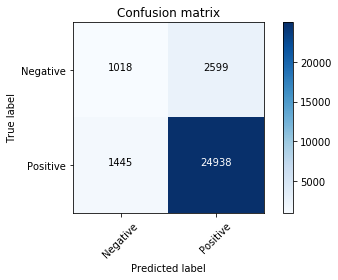

In [65]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_tfidf), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [70]:
acc_bow = accuracy_score(y_test, y_pred_tfidf, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (10000, acc_bow))


The accuracy of C with value 10000.000000 is 86.520000%


In [72]:
print ("The error for with C = 10000 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 10000 is 


13.480000000000004

In [68]:
important_features (tf_idf_vect,clf4,'positive',50)

Important words in positive reviews
o 0.7147080245728334 bit
o 0.6098413098359216 also
o 0.5313447425927107 best
o 0.5232499296673415 amazon com
o 0.514477627127683 anyth
o 0.49919982857677814 brand
o 0.46814307526045296 add
o 0.462048785174653 delici
o 0.45531088001259634 blend
o 0.4511043482651237 area
o 0.3976513011159848 alway
o 0.3850423555360943 bag
o 0.36944623152149825 absolut
o 0.3516995689831888 amaz
o 0.3458395217793035 bake
o 0.34215594397259735 age
o 0.33585026320901923 best tast
o 0.33280125130607635 also make
o 0.31844265349017364 dog love
o 0.31233948573578296 ask
o 0.29721236468726786 came
o 0.28927422290116206 balanc
o 0.2883033488134393 arriv
o 0.28704597501116397 better price
o 0.2786475884318416 buy
o 0.2693161597674697 abl get
o 0.26816380183875477 brew
o 0.26789436013958295 arriv time
o 0.26282382743856464 cold
o 0.26064259539553886 arriv quick
o 0.25861435389000786 along
o 0.25825082261332505 anywher
o 0.2575133631587875 amazon carri
o 0.2559710599705278 allergi

In [69]:
important_features (tf_idf_vect,clf4,'negative',50)

Important words in negative reviews
n -0.19361344058829133 avoid product
n -0.13119034840803076 anyth like
n -0.12461229500357175 anyth special
n -0.1217784236788703 away rest
n -0.11920152212571096 bad tast
n -0.11665238466390737 advis ad
n -0.10880500868795485 worth
n -0.10737625509622759 disappoint product
n -0.10005809733495892 absolut horribl
n -0.09931719644882041 arriv hard
n -0.09742023231611914 china would
n -0.09698444225488169 bag stale
n -0.09629795755414534 absolut terribl
n -0.09430426036075579 away wast
n -0.09260423523582445 beyond what
n -0.09210311054197762 disappoint say
n -0.09184805619614456 aw tast
n -0.09092095810414501 away pretti
n -0.08977923103871663 bag jerki
n -0.08962399656236492 absolut disgust
n -0.08904959512371406 bland would
n -0.08901980402777909 bewar
n -0.08871703168147034 box meijer
n -0.08842339399214565 curri steak
n -0.08769631706591585 chew lost
n -0.08705660704397263 bold long
n -0.08672381217024888 coffe weak
n -0.08603764834491245 deal thic

# L2 Regularizer

In [71]:

import numpy as np

clf5 = LogisticRegression(C=10000, penalty='l2');
clf5.fit(X2_train, y_train);
y_pred_tfidf2 = clf5.predict(X2_test)
w = clf5.coef_
print ("The Weight with C = 10000 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 10000 with L2 Reg
931334


In [73]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_tfidf2, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.9041800610961692, 0.8993333333333333, 0.8673383617021605, None)

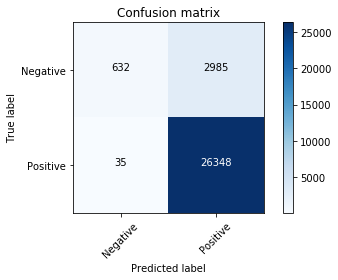

In [74]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_tfidf2), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [75]:
acc_bow = accuracy_score(y_test, y_pred_tfidf2, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (10000, acc_bow))


The accuracy of C with value 10000.000000 is 89.933333%


In [76]:
print ("The error for with C = 10000 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 10000 is 


10.066666666666663

In [77]:
important_features (tf_idf_vect,clf5,'positive',50)

Important words in positive reviews
o 0.2624836642371254 great
o 0.2550295376748473 love
o 0.20857006481691198 good
o 0.18513930720371413 best
o 0.14203310740248853 excel
o 0.14072723597564582 delici
o 0.11790117546302108 find
o 0.11787914762704221 use
o 0.11782511785008884 favorit
o 0.11435951564890244 product
o 0.1098969787593952 make
o 0.10754345125398439 price
o 0.1049320520565311 flavor
o 0.10234896352685811 tasti
o 0.10176209545373416 wonder
o 0.09963981249608868 easi
o 0.09754277507314778 nice
o 0.09745059366399601 perfect
o 0.09557091994897492 like
o 0.09547395529481016 tast
o 0.09397805497310545 store
o 0.09196188587349638 enjoy
o 0.08984420480700393 thank
o 0.08898594679404474 time
o 0.08823508587172774 realli
o 0.08785964007100848 quick
o 0.08657382580541775 recommend
o 0.08602446477991871 tri
o 0.085866384367332 snack
o 0.08544842332283135 tea
o 0.08382888299275358 coffe
o 0.08303781251445978 tast great
o 0.08241438083799067 high
o 0.08225421826809423 get
o 0.08177622667253

In [78]:
important_features (tf_idf_vect,clf5,'negative',50)

Important words in negative reviews
n -0.10690384990512009 worth
n -0.0799980382918797 worst
n -0.07722618553910415 disappoint
n -0.06997704843677054 store per
n -0.06822308219995162 wast money
n -0.06500750002272386 terribl
n -0.06260566050834368 horribl
n -0.061465148250687905 second least
n -0.05849766254731329 wont buy
n -0.0574323361552847 threw
n -0.05641953033202475 stale
n -0.05369835624506698 bitter would
n -0.0532628803459027 brand next
n -0.05290474419206534 wast
n -0.05016907851703438 bitter cup
n -0.04978820883293432 worst tast
n -0.04879516230565309 never buy
n -0.04779611614057276 disappoint product
n -0.047719542646586004 aw
n -0.04677522576676933 purchas cheaper
n -0.04610823134628733 cooki spici
n -0.04602961166713645 return
n -0.04357581356277138 anymor sure
n -0.04357458585504545 absolut worst
n -0.04218699185744091 drink black
n -0.041661885927652895 one hous
n -0.04126232632995484 tri pamela
n -0.04120191567736635 dont wast
n -0.04092405056226083 item three
n -0.0

# Randomized SearchCV in TFIDF

In [41]:
tuned_parameters = {'C':stats.uniform(10**-4,10**4)}

model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)
model.fit(X2_train, y_train)


print(model.best_estimator_)
print ("The F1 score is :")
print(model.score(X2_test, y_test))


LogisticRegression(C=9643.522337430168, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The F1 score is :
0.8672374208413115


# L1 Regularizer

In [43]:

import numpy as np

clf6 = LogisticRegression(C=9643.52, penalty='l1');
clf6.fit(X2_train, y_train);
y_pred_tfidf3 = clf6.predict(X2_test)
w = clf6.coef_
print ("The Weight with C = 9643.52 with L1 Reg is ")
print(np.count_nonzero(w))


The Weight with C = 9643.52 with L1 Reg is 
755261


In [43]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_tfidf3, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8481058428587828, 0.8665666666666667, 0.855461576158595, None)

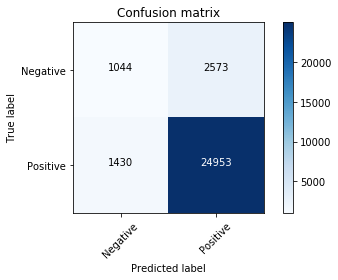

In [44]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_tfidf3), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [45]:
acc_bow = accuracy_score(y_test, y_pred_tfidf3, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (9643.52, acc_bow))


The accuracy of C with value 9643.520000 is 86.656667%


In [46]:
print ("The error for with C = 9643.52 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 9643.52 is 


13.343333333333334

In [44]:
important_features (tf_idf_vect,clf6,'positive',50)

Important words in positive reviews
o 0.7805851422848085 best
o 0.6437717464022741 brand
o 0.5471925306762978 bake
o 0.5267420064891792 becom
o 0.5219635130896211 altern
o 0.4691994108976752 along
o 0.4647695209909388 also
o 0.4531648695368964 beat
o 0.44493455569481705 bit
o 0.42736438082825223 abl
o 0.39978273228158856 best price
o 0.37468194971537333 better
o 0.35629004605530856 bold
o 0.35259373875526995 also great
o 0.34501177391048365 absolut love
o 0.32280330250181904 easi
o 0.32266019824282455 amount
o 0.31076413125948393 add
o 0.30859234662492174 although
o 0.30373644164287644 came
o 0.3035738990555504 banana
o 0.302947712419176 cat love
o 0.29348442081609094 combin
o 0.29330673825054165 add littl
o 0.29195705880728795 arriv time
o 0.2827869611234785 bitter
o 0.2806144130623192 chew
o 0.2784637834447347 afternoon
o 0.27513370808346144 alon
o 0.2706626154890317 cereal
o 0.26966820314720835 arriv good
o 0.26249884013302155 actual tast
o 0.26034729172161325 blend
o 0.257329598136

In [45]:
important_features (tf_idf_vect,clf6,'negative',50)

Important words in negative reviews
n -0.25753988656517474 aw
n -0.1589361979100469 avoid product
n -0.1452234905682261 dont wast
n -0.13115139957231678 cant return
n -0.1260097832134267 big disappoint
n -0.11115853490897994 allow return
n -0.11108918870549474 bad tast
n -0.11047996031750304 absolut worst
n -0.10724318930862667 worth
n -0.10655272122938775 anyth special
n -0.10596405554390924 away rest
n -0.10591411925187884 absolut horribl
n -0.10545061367309125 bad go
n -0.10269270193139868 box salt
n -0.09923305129513033 although coffe
n -0.09921041203356012 aw could
n -0.09794206025076503 content encourag
n -0.09772519825749588 agricultur product
n -0.09479519537602875 anyon unless
n -0.09403239070610891 bland
n -0.09212596608116543 aw tast
n -0.0899111510637319 amazon refund
n -0.08989802944509165 came microwav
n -0.08948893036435403 email stuff
n -0.08947505764988357 deal thicker
n -0.0889412111072594 bold didnt
n -0.08844282940953634 care textur
n -0.08819118291139955 away wont


# L2 regularizer

In [46]:

import numpy as np

clf7 = LogisticRegression(C=9643.52, penalty='l2');
clf7.fit(X2_train, y_train);
y_pred_tfidf4 = clf7.predict(X2_test)
w = clf7.coef_
print ("The Weight with C = 9643.52 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 9643.52 with L2 Reg
931334


In [48]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_tfidf4, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.9042822494094185, 0.8993, 0.8672374208413115, None)

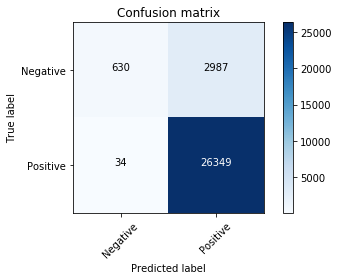

In [49]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_tfidf4), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [50]:
acc_bow = accuracy_score(y_test, y_pred_tfidf4, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (9643.52, acc_bow))


The accuracy of C with value 9643.520000 is 89.930000%


In [51]:
print ("The error for with C = 9643.52 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 9643.52 is 


10.070000000000007

In [47]:
important_features (tf_idf_vect,clf7,'positive',50)

Important words in positive reviews
o 0.26234480387651826 great
o 0.2548875695392372 love
o 0.20842689838457187 good
o 0.1850366612282678 best
o 0.14181727671312602 excel
o 0.1406698535182094 delici
o 0.11795051723821778 find
o 0.11791581082894831 use
o 0.11780545406508838 favorit
o 0.11426410987188715 product
o 0.10997313993813428 make
o 0.10752352006858076 price
o 0.1049306435799866 flavor
o 0.1022954644257105 tasti
o 0.10174207425572106 wonder
o 0.09962177014899923 easi
o 0.09752626108373579 nice
o 0.09747577582599322 perfect
o 0.09552380243629269 like
o 0.09540941477501776 tast
o 0.09401556477039558 store
o 0.09195702291252279 enjoy
o 0.08983445620313316 thank
o 0.08901442101776381 time
o 0.08822617356846958 realli
o 0.08782968953372511 quick
o 0.08661697532671121 recommend
o 0.08606572718374288 tri
o 0.08588093827901562 snack
o 0.08545280569326402 tea
o 0.08380717215959824 coffe
o 0.08298996645450278 tast great
o 0.08245805161686139 high
o 0.08228052850275262 get
o 0.0817495572299

In [48]:
important_features (tf_idf_vect,clf7,'negative',50)

Important words in negative reviews
n -0.1067403404828663 worth
n -0.07998680004438602 worst
n -0.07720015083177342 disappoint
n -0.06994623816766622 store per
n -0.06820534404717885 wast money
n -0.06498180757098627 terribl
n -0.06259171663268474 horribl
n -0.061392141912986586 second least
n -0.05848765787634797 wont buy
n -0.05741240321717791 threw
n -0.056400698745732 stale
n -0.053650396636420766 bitter would
n -0.05322995118659928 brand next
n -0.05289587558213015 wast
n -0.05011880538812031 bitter cup
n -0.049755650667845236 worst tast
n -0.04877622620378357 never buy
n -0.047795429552064235 disappoint product
n -0.04771938226086308 aw
n -0.04674731894812387 purchas cheaper
n -0.04606260995327181 cooki spici
n -0.046022508694568906 return
n -0.04359823424621494 absolut worst
n -0.043555770217068406 anymor sure
n -0.04215827813990867 drink black
n -0.041626029356840046 one hous
n -0.04123507661546354 tri pamela
n -0.04120041806639253 dont wast
n -0.04089277850598603 item three
n 

# Conclusion for TFIDF 

| Parameters | SearchCV |  Value of C   | F1 Score | Weight W  | Accuracy | Error
|------------|--------|
|  L1     |  GridsearchCV  | 10000 | 0.86 | 755611 | 86.52 | 13.48 |  
|  L2    |  GridSearchCV | 10000 | 0.86 | 931334 | 89.93 | 10.06 |
|  L1     |  RandomsearchCV  | 9643.52 | 0.86 | 755261 | 86.65 | 13.34 | 
|  L2    |  RandomsearchCV | 9643.52 | 0.86 | 931334 | 89.93 | 10.07 | 




### Observations : 
### 1. The L2 model has more accuracy for both GridsearchSearch and Random Search.
### 2. The value of C is lesser in gridsearch  so the value of lambda would be more, Bias would be more and latency would be less.
### 3. With High value of C, lambda decreases with increase in Weight with decrease in sparsity.
### 4. The Weight,Accuracy of L1 and L2 is same for Gridsearch and Randomsearch respectively.
     

# AVG Word2Vec


In [50]:
#Word 2 Vector for train corpus
list_of_sent_train=[]#Stored in a list
for sent in x_train:
    list_of_sent_train.append(sent.split())
    
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
print(w2v_model_train)

w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

Word2Vec(vocab=10698, size=50, alpha=0.025)
number of words that occured minimum 5 times  10698
sample words  ['decid', 'roll', 'dice', 'bought', 'spring', 'onion', 'split', 'pea', 'soup', 'sinc', 'like', 'drink', 'wasnt', 'disappoint', 'littl', 'scare', 'first', 'time', 'order', 'food', 'type', 'item', 'amazon', 'sister', 'thought', 'crazi', 'someth', 'normal', 'dont', 'far', 'favorit', 'tri', 'bland', 'tast', 'compar', 'ambrosia', 'tomorrow', 'season', 'perfect', 'light', 'good', 'expect', 'come', 'cup', 'noodl', 'best', 'microwav', 'ever', 'know', 'might']


In [51]:
#Word 2 Vector for test corpus
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
print(w2v_model_test)

w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

Word2Vec(vocab=7458, size=50, alpha=0.025)
number of words that occured minimum 5 times  7458
sample words  ['like', 'organ', 'whole', 'grain', 'brown', 'rice', 'take', 'look', 'label', 'milk', 'product', 'two', 'thing', 'dont', 'often', 'see', 'find', 'togeth', 'one', 'made', 'favorit', 'far', 'three', 'boy', 'love', 'even', 'mix', 'unsweeten', 'soy', 'cut', 'sugar', 'high', 'recommend', 'anyon', 'want', 'need', 'avoid', 'dairi', 'that', 'posit', 'say', 'arent', 'lot', 'choic', 'decaf', 'tassimo', 'moment', 'make', 'brew', 'cup']


In [52]:
#train corpus
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            #print(word)
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

70000
50


In [53]:
#test Corpus
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
    
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [54]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=False, with_std=True)
X_train_avgw2v = scaler.fit_transform(sent_vectors_train)
X_test_avgw2v = scaler.fit_transform(sent_vectors_test)


In [50]:


tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)
model.fit(X_train_avgw2v, y_train)


print(model.best_estimator_)
print ("The F1 score is :")
print(model.score(X_test_avgw2v, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The F1 score is :
0.8132141540056762


# L1 regularizer

In [55]:

import numpy as np

clf8 = LogisticRegression(C=1, penalty='l1');
clf8.fit(X_train_avgw2v, y_train);
y_pred_avgw2v = clf8.predict(X_test_avgw2v)
w = clf8.coef_
print ("The Weight with C = 1 with L1 Reg is ")
print(np.count_nonzero(w))


The Weight with C = 1 with L1 Reg is 
50


In [52]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8315780466439135, 0.8604333333333334, 0.8145843911537185, None)

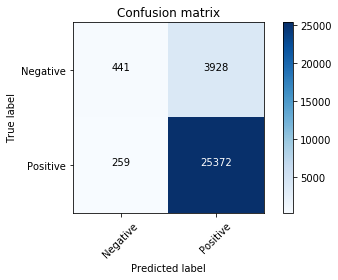

In [53]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [54]:
acc_bow = accuracy_score(y_test, y_pred_avgw2v, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (1, acc_bow))


The accuracy of C with value 1.000000 is 86.043333%


In [55]:
print ("The error for with C = 1 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 1 is 


13.956666666666663

# L2 Regularizer

In [56]:

import numpy as np

clf = LogisticRegression(C=1, penalty='l2');
clf.fit(X_train_avgw2v, y_train);
y_pred_avgw2v2 = clf.predict(X_test_avgw2v)
w = clf.coef_
print ("The Weight with C = 1 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 1 with L2 Reg
50


In [57]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v2, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8302737696063165, 0.8599333333333333, 0.8132141540056762, None)

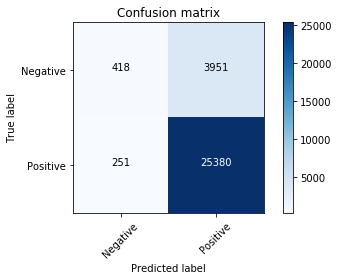

In [58]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v2), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [59]:
acc_bow = accuracy_score(y_test, y_pred_avgw2v2, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (1, acc_bow))


The accuracy of C with value 1.000000 is 85.993333%


In [60]:
print ("The error for with C = 1 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 1 is 


14.00666666666666

# Random searchCV

In [100]:
tuned_parameters = {'C':stats.uniform(10**-4,10**4)}

model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)
model.fit(X_train_avgw2v, y_train)


print(model.best_estimator_)
print ("The F1 score is :")
print(model.score(X_test_avgw2v, y_test))


LogisticRegression(C=8847.315281955944, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The F1 score is :
0.8127999994106273


# L1 Regularizer

In [102]:

import numpy as np

clf = LogisticRegression(C=8847.31, penalty='l1');
clf.fit(X_train_avgw2v, y_train);
y_pred_avgw2v3 = clf.predict(X_test_avgw2v)
w = clf.coef_
print ("The Weight with C = 8847.31 with L1 Reg is ")
print(np.count_nonzero(w))


The Weight with C = 8847.31 with L1 Reg is 
50


In [103]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v3, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8315454508334533, 0.8604333333333334, 0.8146294636318775, None)

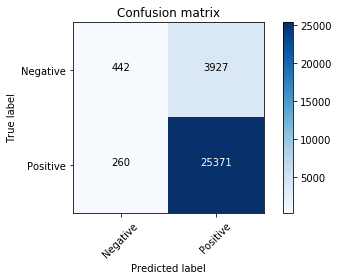

In [104]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v3), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [105]:
acc_bow = accuracy_score(y_test, y_pred_avgw2v3, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (8847.31, acc_bow))


The accuracy of C with value 8847.310000 is 86.043333%


In [106]:
print ("The error for with C = 8847.31 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 8847.31 is 


13.956666666666663

# L2 Regularizer

In [107]:

import numpy as np

clf = LogisticRegression(C=8847.31, penalty='l2');
clf.fit(X_train_avgw2v, y_train);
y_pred_avgw2v4 = clf.predict(X_test_avgw2v)
w = clf.coef_
print ("The Weight with C = 8847.31 with L1 Reg is ")
print(np.count_nonzero(w))


The Weight with C = 8847.31 with L1 Reg is 
50


In [108]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v4, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8305849465191899, 0.8599333333333333, 0.8127999994106273, None)

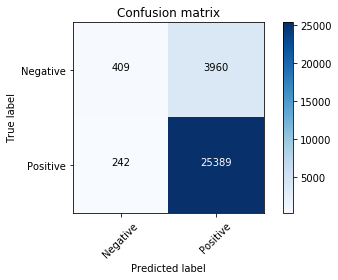

In [109]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v4), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [110]:
acc_bow = accuracy_score(y_test, y_pred_tfidf4, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (8847.31, acc_bow))


The accuracy of C with value 8847.310000 is 88.613333%


In [111]:
print ("The error for with C = 8847.31 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 8847.31 is 


11.38666666666667

# Conclusion for AVGW2V

| Parameters | SearchCV |  Value of C   | F1 Score | Weight W  | Accuracy | Error
|------------|--------|
|  L1     |  GridsearchCV  | 1 | 0.81 | 50 | 86.04 | 13.95 
|  L2    |  GridSearchCV | 1 | 0.82 | 50 | 85.99 | 14.00
|  L1     |  RandomsearchCV  | 8847.31 | 0.81 | 50 | 86.04 | 13.95 
|  L2    |  RandomsearchCV | 8847.31 | 0.82 | 50 | 88.61 | 11.38




### Observation : All the values are same irrespective of model or parameters.The Weight,Accuracy and value of C remains same all over.

# Avg TF-IDF Word2Vec 

In [57]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [58]:
tfidf_feat = tf_idf_vect.get_feature_names()#getting feature list

In [59]:
from tqdm import tqdm
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))#taking the dictionary to train words to plt vector. 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:27<00:00, 473.51it/s]


70000
50


In [60]:
model = TfidfVectorizer(ngram_range=(1,2))
tf_idf_matrix = model.fit_transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [61]:
#test corpus
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:48<00:00, 622.45it/s]


30000
50


In [62]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=False, with_std=True)
X_train_avgw2v_tfidf = scaler.fit_transform(tfidf_sent_vectors_train)
X_test_avgw2v_tfidf = scaler.fit_transform(tfidf_sent_vectors_test)

# GridSearchCV

In [67]:


tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)
model.fit(X_train_avgw2v_tfidf, y_train)


print(model.best_estimator_)
print ("The F1 score is :")
print(model.score(X_test_avgw2v_tfidf, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The F1 score is :
0.8027908474552626


# L1 regularizer

In [123]:

import numpy as np

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(X_train_avgw2v_tfidf, y_train);
y_pred_avgw2v_tfidf = clf.predict(X_test_avgw2v_tfidf)
w = clf.coef_
print ("The Weight with C = 1 with L1 Reg is ")
print(np.count_nonzero(w))


The Weight with C = 1 with L1 Reg is 
50


In [69]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v_tfidf, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.7968137415993272, 0.8498, 0.8030437383254847, None)

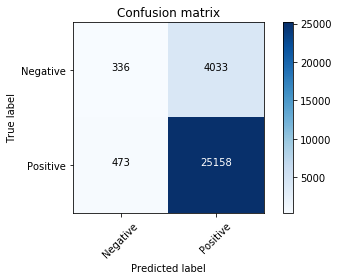

In [70]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v_tfidf), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [71]:
acc_bow = accuracy_score(y_test, y_pred_avgw2v_tfidf, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (1, acc_bow))


The accuracy of C with value 100.000000 is 84.980000%


In [124]:
print ("The error for with C = 1 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 1 is 


15.030000000000001

# L2 Regularizer

In [125]:

import numpy as np

clf = LogisticRegression(C=1, penalty='l2');
clf.fit(X_train_avgw2v_tfidf, y_train);
y_pred_avgw2v_tfidf2 = clf.predict(X_test_avgw2v_tfidf)
w = clf.coef_
print ("The Weight with C = 1 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 1 with L2 Reg
50


In [74]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v_tfidf2, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.7958877253333349, 0.8497, 0.8023762578482575, None)

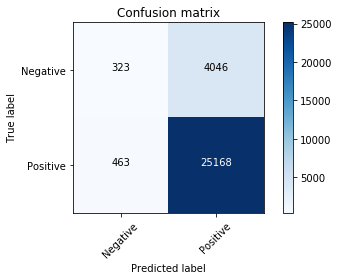

In [75]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v_tfidf2), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [126]:
acc_bow = accuracy_score(y_test, y_pred_avgw2v_tfidf2, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (1, acc_bow))


The accuracy of C with value 1.000000 is 84.976667%


In [127]:
print ("The error for with C = 1 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 1 is 


15.023333333333326

# Random SearchCV

In [101]:
tuned_parameters = {'C':stats.uniform(10**-4,10**4)}

model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=4)
model.fit(X_train_avgw2v_tfidf, y_train)


print(model.best_estimator_)
print ("The F1 score is :")
print(model.score(X_test_avgw2v_tfidf, y_test))


LogisticRegression(C=6268.973290001382, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The F1 score is :
0.8023762578482575


# L1 Regularizer

In [112]:

import numpy as np

clf = LogisticRegression(C=6268.97, penalty='l1');
clf.fit(X_train_avgw2v_tfidf, y_train);
y_pred_avgw2v_tfidf3 = clf.predict(X_test_avgw2v_tfidf)
w = clf.coef_
print ("The Weight with C = 6268.97 with L1 Reg is ")
print(np.count_nonzero(w))


The Weight with C = 6268.97 with L1 Reg is 
50


In [113]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v_tfidf3, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.7958362969948735, 0.8496333333333334, 0.8024290689412801, None)

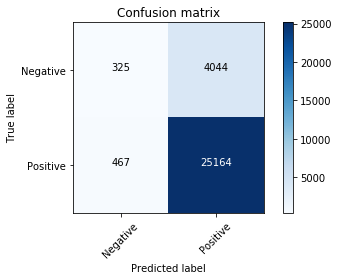

In [114]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v_tfidf3), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [116]:
acc_bow = accuracy_score(y_test, y_pred_avgw2v_tfidf3, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (6268.97, acc_bow))


The accuracy of C with value 6268.970000 is 84.963333%


In [117]:
print ("The error for with C = 6268.97 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 6268.97 is 


15.036666666666662

# L2 Regularizer

In [118]:


clf = LogisticRegression(C=6268.97, penalty='l2');
clf.fit(X_train_avgw2v_tfidf, y_train);
y_pred_avgw2v_tfidf4 = clf.predict(X_test_avgw2v_tfidf)
w = clf.coef_
print ("The Weight with C = 6268.97 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 6268.97 with L2 Reg
50


In [119]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_avgw2v_tfidf4, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.7958877253333349, 0.8497, 0.8023762578482575, None)

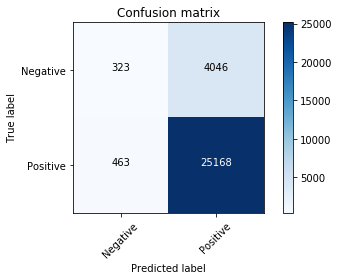

In [120]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_avgw2v_tfidf4), classes=["Negative","Positive"])#Passing Parameters in fn to predict values.

In [121]:
acc_bow = accuracy_score(y_test, y_pred_avgw2v_tfidf4, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (6268.97, acc_bow))


The accuracy of C with value 6268.970000 is 84.970000%


In [122]:
print ("The error for with C = 6268.97 is ")
err_bow = 100-acc_bow
err_bow

The error for with C = 6268.97 is 


15.030000000000001

# Conclusion for AVGW2V TFIDF

| Parameters | SearchCV |  Value of C   | F1 Score | Weight W  | Accuracy | Error
|------------|--------|
|  L1     |  GridsearchCV  | 1 | 0.80 | 50 | 84.98 | 15.01
|  L2    |  GridSearchCV | 1 | 0.80 | 50 | 84.97 | 15.02
|  L1     |  RandomsearchCV  | 6268.97 | 0.80 | 50 | 84.94 | 15.03 
|  L2    |  RandomsearchCV | 6268.97 | 0.80 | 50 | 84.96 | 15.03




### Observation : The F1 score is same for all models and parameters.We can use gridsearchCV or RandomSearchCV for this classifier.The values remains same.

# Pertubation test on  Bag of Words for Logistic Regression

In [78]:
clf = LogisticRegression(C=0.01, penalty='l2');
clf.fit(X1_train, y_train);
y1_pred = clf.predict(X1_test)
w = clf.coef_
print ("The Weight with C = 0.01 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 0.01 with L2 Reg
31512


In [79]:
acc_bow = accuracy_score(y_test, y1_pred, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (0.01, acc_bow))


The accuracy of C with value 0.010000 is 90.256667%


In [80]:
X1_train.data = X1_train.data + 0.01

In [81]:
clf = LogisticRegression(C=0.01, penalty='l2');
clf.fit(X1_train, y_train);
y1_pred = clf.predict(X1_test)
w1 = clf.coef_
print ("The Weight with C = 0.01 with L2 Reg")
w1 = np.count_nonzero(w)
print(w1)


The Weight with C = 0.01 with L2 Reg
31512


In [82]:
acc_bow = accuracy_score(y_test, y1_pred, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (0.01, acc_bow))


The accuracy of C with value 0.010000 is 90.246667%


In [83]:
weights_difference = ((abs(w-w1)/w)*100)

In [84]:
print (weights_difference)

[[ 1.28176794e+11 -1.16974487e+09  3.38940525e+09 ...  7.09543342e+09
   3.23623563e+09  1.36165500e+09]]


In [85]:
print(weights_difference[np.where(weights_difference > 20)].size)

20413


# Conclusion for Pertubation test  
### 1. 20413 features have wieght changes or different weight greater than 20%.
### 2. They are Multi - Collinear, So we will not take W to depict Feature importance.

## Changing values of C

In [86]:
clf = LogisticRegression(C=100, penalty='l1');
clf.fit(X1_train, y_train);
y1_pred = clf.predict(X1_test)
w = clf.coef_
print ("The Weight with C = 0.01 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 0.01 with L2 Reg
15546


In [87]:
acc_bow = accuracy_score(y_test, y1_pred, normalize=True) * float(100)
print('\nThe accuracy of C with value %f is %f%%' % (100, acc_bow))


The accuracy of C with value 100.000000 is 86.366667%


In [88]:
clf = LogisticRegression(C=50, penalty='l1');
clf.fit(X1_train, y_train);
y_pred_test = clf.predict(X1_test)
w = clf.coef_
print ("The Weight with C = 0.01 with L2 Reg")
print(np.count_nonzero(w))


The Weight with C = 0.01 with L2 Reg
15201


### Observations : As the Value of C decreases, the Lambda would increases, So our Weight decreases with increase in sparsity with increase in bias with our model being of low Latency